In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df=pd.read_csv('train.csv')
n_row, n_col = df.shape


In [11]:
y=df['SalePrice']
plt.figure(figsize=(16,5))
#plt.plot(df['Alley'],y)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

<Figure size 1152x360 with 0 Axes>

In [2]:
#replace some na
df['Alley'].fillna('None',inplace=True)
df['Fence'].fillna('None',inplace=True)
df['FireplaceQu'].fillna('None',inplace=True)
df['GarageFinish'].fillna('None',inplace=True)
df['GarageQual'].fillna('None',inplace=True)
df['GarageType'].fillna('None',inplace=True)
df['MasVnrType'].fillna('None',inplace=True)
df['MasVnrArea'].fillna(0,inplace=True)
df['Condition1'].fillna('Normal',inplace=True)
df['Condition2'].fillna('Normal',inplace=True)
df['LotFrontage'].fillna(0,inplace=True)

In [3]:
#Set ordinal varibables to get dummy coded   ---'YearBuilt', 'YearRemodAdd', 'YrSold','GarageYrBlt',
ordinal_cols=['MSSubClass','OverallQual','OverallCond','MoSold',
             'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath', 'BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces']
df[ordinal_cols]=df[ordinal_cols].astype("category")

"""

""";

In [4]:
#drop some columns (with over 90% missing data)
df.drop(columns='PoolQC', inplace=True)
df.drop(columns='MiscFeature', inplace=True)

df.drop(columns="Id", inplace=True)

In [5]:
#fuction to predict missing values ----- TODO
def predict_na(df, targ, pred):
    X = df[pred].loc[~df[targ].isna()]
    y = df[[targ]].loc[~df[targ].isna()]
    X['bias']=1

    w=np.linalg.solve(X.T.dot(X),X.T.dot(Y))
    X=df[pred].loc[df[targ].isna()]
    X['bias']=1

    df[[targ]].loc[df[targ].isna()]=X.dot(w)

In [6]:
#drop any na that wasn't replaced 
df.dropna(inplace=True)

#normalize
quant_cols=np.hstack([df.T.loc[df.dtypes=='int64'].index,df.T.loc[df.dtypes=='float64'].index]).T
df[quant_cols] = (df[quant_cols] - df[quant_cols].min())/(df[quant_cols].max() - df[quant_cols].min())

#add bias column
if (any(df.columns=='ones')):
    df.drop(columns='ones',inplace=True)
df.insert(0,column='ones', value=1)
quant_cols=np.hstack([df.T.loc[df.dtypes=='int64'].index,df.T.loc[df.dtypes=='float64'].index]).T


In [7]:
#useful function
def SS(x,y):
    return x.T.dot(y)

#functions to train, validate and test
def SplitDataFrame(df):
    n=df.shape[0]
    rand_rows=np.random.choice(n,n,replace=False)
    df_train =  df.iloc[rand_rows[:int(n * 0.6)]]
    df_validate = df.iloc[rand_rows[int(n * 0.6):int(n * 0.8)]]
    df_test = df.iloc[rand_rows[int(n * 0.8):]]
    return [df_train, df_validate, df_test]


def TrainModel(X,y,l, bias):
    reg=np.eye(X.shape[1])*l
    reg[0][0]=bias
    return np.linalg.solve(SS(X,X) + reg, SS(X,y))
    
def GradientDescent(x,y, l1, l2, eta, epochs):
    J=np.zeros(epochs)
    w=np.random.randn(x.shape[1])
    for t in range(epochs):
            y_hat = x.dot(w)
            J[t]=(SS(y,y_hat)+l1*np.sum(np.abs(w))+l2*SS(w,w))
            w -= eta*(x.T.dot(y_hat-y)+l1*np.sign(w) + l2*w)
    return w
    
def ValidateModel(X, y, w):
    y_hat=X.dot(w)
    return SS(y - y_hat,y - y_hat )
    

In [9]:
#Split the data into training/validate/test
train_data, validate_data, test_data=SplitDataFrame(pd.get_dummies(df))
#train_data, validate_data, test_data=SplitDataFrame(df[quant_cols])

In [10]:
y_col='SalePrice'

y_train=train_data[y_col]
x_train=train_data.drop(columns=y_col)

y_valid=validate_data[y_col]
x_valid=validate_data.drop(columns=y_col)

y_test=test_data[y_col]
x_test=test_data.drop(columns=y_col)

In [11]:
def fit_gd(x,y,l1,l2):
    eta= 1e-5
    epochs=int(1e3)
    return GradientDescent(x, y, l1, l2, eta, epochs) 

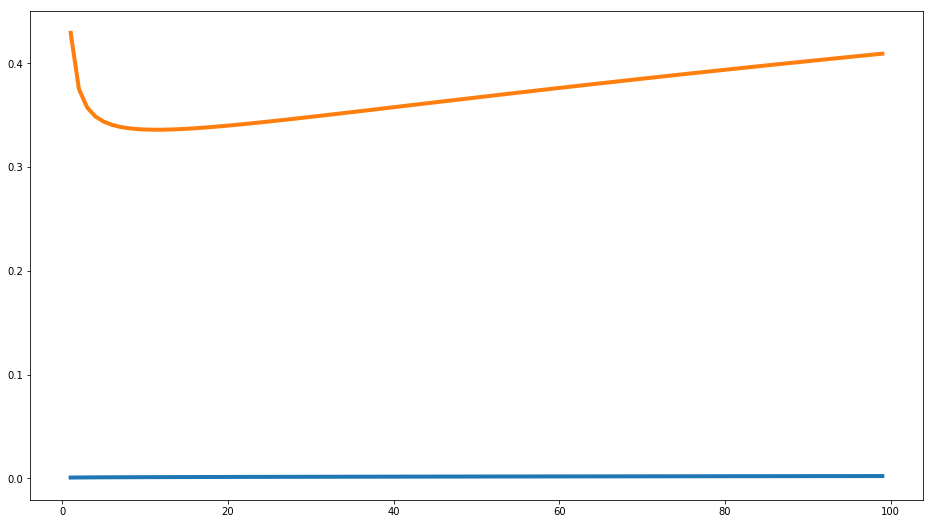

In [17]:
L=np.arange(1,100)
J=[]
J2=[]
for l in L:
    for b in [0,1]:
        w=TrainModel(x_train,y_train,l, b)  
        J.append([l,b, ValidateModel(x_valid, y_valid, w)])
        J2.append([l,b, ValidateModel(x_train, y_train, w)])

J=pd.DataFrame(J, columns=['L','b','J'])
J2=pd.DataFrame(J2, columns=['L','b','J'])

fig=plt.figure(figsize=(16,9))
#plt.plot(J2.loc[J2['b']==0,'L'],J2.loc[J2['b']==0,'J'], color='blue');
plt.plot(J2.loc[J2['b']==1,'L'],J2.loc[J2['b']==1,'J']/807, label='training', linewidth=4);
plt.plot(J.loc[J['b']==1,'L'],J.loc[J['b']==1,'J'], label='validate', linewidth=4);
#fig.savefig('validTest.png')


In [13]:
w_best=TrainModel(x_train,y_train,12, 1)
J_best=ValidateModel(x_test, y_test, w_best)
print('best R^2 is {}'.format(1-J_best/SS(y_test - y_test.mean(), y_test - y_test.mean())))

y_hat=x_test.dot(w_best)
print('median percent error: {}'.format(np.median(np.abs((y_hat - y_test)/y_test))))


best R^2 is 0.8547680556875542
median percent error: 0.09250745949010913


In [14]:
L=np.arange(15,3)
J=[]
J2=[]
for l in L:
    for b in [0,1]:
        w=GradientDescent(x,y, l, 0, eta, epochs)  
        J.append([l,b, ValidateModel(x_valid, y_valid, w)])
        J2.append([l,b, ValidateModel(x_train, y_train, w)])

J=pd.DataFrame(J, columns=['L','b','J'])
J2=pd.DataFrame(J2, columns=['L','b','J'])

In [ ]:
#ElasticNet Regularization
L1=np.arange(0,30,3)
L2=np.arange(0,50,3)



J_valid=np.zeros(L1.shape[0] * L2.shape[0])
counter=0
plt.figure(figsize=(16,9))
for l1 in L1:
    for l2 in L2:
        w=fit_gd(x_train,y_train,l1,l2)    
        J_valid[counter]=(ValidateModel(x_valid, y_valid, w))
        counter+=1

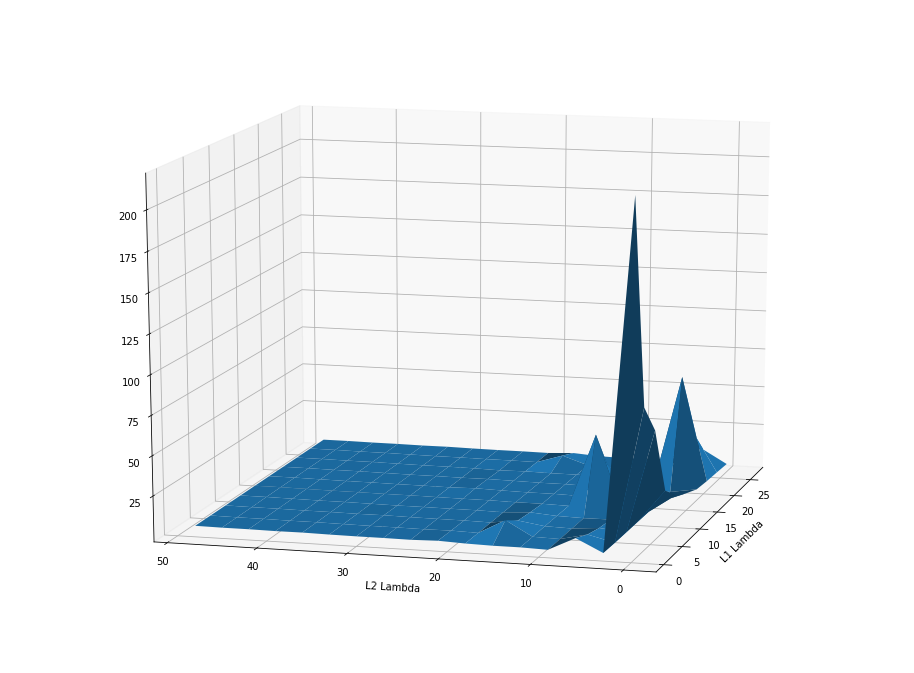

In [376]:
from mpl_toolkits.mplot3d import Axes3D # This import has side effects required for the kwarg projection='3d' in the call to fig.add_subplot

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

l1_mesh, l2_mesh = np.meshgrid(L1,L2)
J_mesh=np.array(J_valid).reshape(l1_mesh.shape)
ax.plot_surface(l1_mesh,l2_mesh,J_mesh)

ax.set_xlabel('L1 Lambda')
ax.set_ylabel('L2 Lambda')
ax.view_init(14,195)
plt.show()


#fig.savefig('elestiFitMassive.png')
#Image.open('elestiFit.png').save('elestiFit.jpg','JPEG')

#np.stack([J_mesh, l2_mesh]).T

array([], dtype=float64)

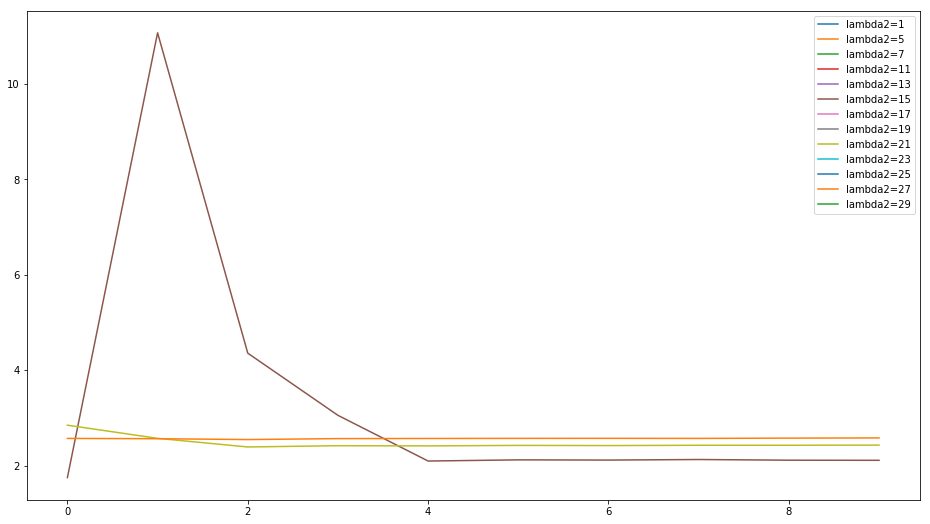

In [373]:
min2=40
l1v=l1_mesh[l2_mesh>min2]
Jv=J_mesh[l2_mesh>min2]
l2v=l2_mesh[l2_mesh>min2]

[l1v[Jv==Jv.min()], l2v[Jv==Jv.min()]]

plt.figure(figsize=(16,9))
for i in range(1,30,2):
    if (i == 3) or (i == 9):
        continue
    Jv=J_mesh[l2_mesh==i]
    plt.plot(Jv, label="lambda2={}".format(i))
    
plt.legend()
    
Jv
    #l1v=l1_mesh[l2_mesh==6]
#Jv[l1v==13]

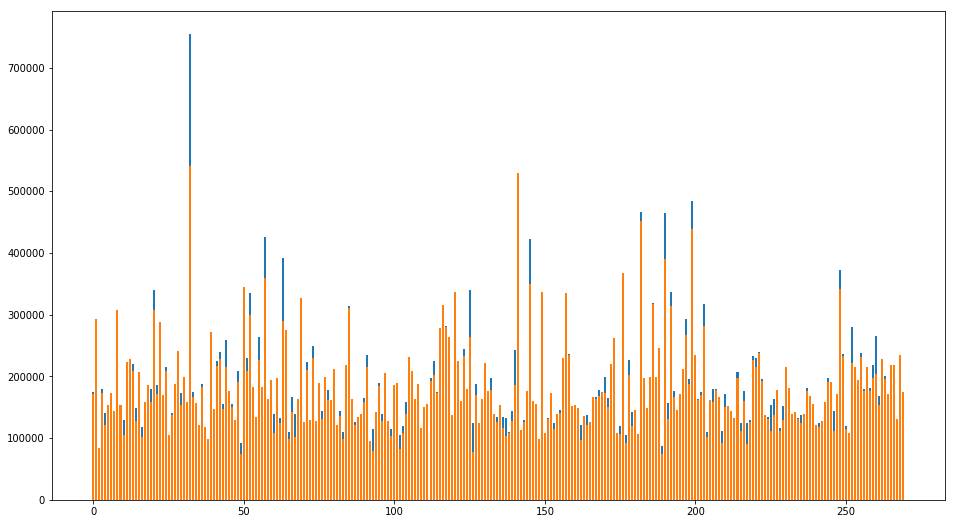

In [480]:

w=TrainModel(x_train,y_train,8, 1)
y_hat_test=x_test.dot(w)

yhT=y_hat_test * rng + mn
yT=y_test * rng + mn

fig=plt.figure(figsize=(16,9))
plt.bar(np.arange(y_hat_test.shape[0]),height=yT, width=.667)
plt.bar(np.arange(y_hat_test.shape[0]),height=yhT, width=.667);
fig.savefig('AbsoluteErrBar.png')
